## Importar lo importante

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import datetime as dt
import pickle
import numpy as np
import borrador
from __future__ import division
from auxiliar_functions import *
import tfe
from geopy.distance import vincenty
from itertools import chain, combinations
import random
import scipy as sp

## Funciones Auxiliares

In [2]:
#Función que filtra columnas de acuerdo a una lista de indices
#filter_features: matrix list -> matrix
def filter_features(vector,selected_features):
    selected = []
    for i in range(len(selected_features)):
        selected.append(features_dict[selected_features[i]])
    return vector[:,selected]

In [3]:
def only_one_match_home_and_work(limit,shared_rois):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    for i in range(limit):
        neighbours = get_neighbours_index(shared_rois,i,2)
        if len(neighbours) > 0:
            if len(neighbours) == 1:
                a_matrix[i,neighbours[0]] = 0
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [6]:
def random_match_home_and_work(limit,shared_rois):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    for i in range(limit):
        neighbours = get_neighbours_index(shared_rois,i,2)
        n_neighbours = len(neighbours)
        if n_neighbours > 0:
            if n_neighbours == 1:
                a_matrix[i,neighbours[0]] = 0
            else:
                random_neighbour = random.choice(neighbours)
                a_matrix[i,random_neighbour] = 0
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [230]:
def compare_vectors_with_neighbours(vector_a,vector_b,rois_a,rois_b,shared_rois,limit,min_shared,f_normalizar,f_distancia):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    for i in range(limit):
        #print "Usuario ",i
        neighbours = get_neighbours_index(shared_rois,i,min_shared)
        if len(neighbours) > 0:
            if len(neighbours) == 1:
                a_matrix[i,neighbours[0]] = 0
            else:
                a_sequence = vector_a[i,:]
                b_sequences = vector_b[neighbours,:]
                ab_sequences = np.vstack((a_sequence,b_sequences))
                for i in range(ab_sequences.shape[1]):
                    ab_sequences[:,i] = f_normalizar(ab_sequences[:,i])
                counter = 0
                for neighbour in neighbours:
                    dist = np.linalg.norm(np.asarray(ab_sequences[0,:])-np.asarray(ab_sequences[counter+1,:]))
                    a_matrix[i,neighbour] = -dist
                    counter += 1
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [211]:
np.vstack((septiembre_vectors[0],septiembre_vectors[[1,2,3,4]])).shape

(5, 19)

In [10]:
def get_n_correct(a_matrix,limit):
    identified_indexs = [] #almacena los indices de que secuencia fue seleccionada como match
    wrong_indexs = [] # almacena los indices de los que se clasificaron incorrectamente
    correct_indexs = [] # almacena los indices de los que se clasificaron correctamente
    selected_distance = [] # almacena la distancia de los seleccionados
    abstenidos = []
    n_identified = 0
    for i in range(limit):
        the_index = np.argmax(a_matrix[:,i])
        selected_distance.append(a_matrix[the_index,i])
        identified_indexs.append(the_index)
        if a_matrix[the_index,i] == -1:
            abstenidos.append(the_index)
        elif(the_index!=i):
            wrong_indexs.append(the_index)
        else:
            correct_indexs.append(the_index)
            n_identified += 1
    return [n_identified,selected_distance,identified_indexs,abstenidos]


In [229]:
#normalizar: [float] -> [float(0,1)]
#Normalizacion mayor menor
def normalizar(vector):
    a_max = np.max(vector)
    a_min = np.min(vector)
    if a_max == 0 and a_min == 0:
        return vector
    if a_max == 0:
        a_max= a_min*0.0000001
    for i in range(len(vector)):
        vector[i] = (vector[i] - a_min)/a_max
    return vector    

In [12]:
#get_neighbours_index: np.matrix int -> np.array
#obtiene los vecinos del usuario "user",
#considerando como vecino a quien comparte dos ubicaciones
def get_neighbours_index(shared_rois,user,min_shared):
    neighbours = np.where(shared_rois[user] >= min_shared)
    return neighbours[0]

In [66]:
get_neighbours_index(shared_rois,6,2)

array([   6, 1672])

In [67]:
abril_vectors[1672]

array([  6.47600000e+02,   8.18800000e+02,   5.47940616e+01,
         6.40165734e+00,   4.86457203e+00,   2.84950935e+03,
         1.48547530e+00,   1.58496250e+00,   4.00000000e+01,
         2.00000000e+01,   0.00000000e+00,   3.81390000e+04,
         7.93550000e+04,   5.00000000e+00,   4.00000000e+00,
         5.00000000e+00,   0.00000000e+00,   1.00000000e+02,
         0.00000000e+00])

In [68]:
septiembre_vectors[1672]

array([  6.32200000e+02,   7.82600000e+02,   6.09424028e+01,
         6.40165734e+00,   4.86457203e+00,   3.11353415e+03,
         1.36096405e+00,   1.58496250e+00,   4.00000000e+01,
         2.00000000e+01,   0.00000000e+00,   3.76510000e+04,
         7.56060000e+04,   5.00000000e+00,   4.00000000e+00,
         5.00000000e+00,   0.00000000e+00,   1.00000000e+02,
         0.00000000e+00])

## Obtener datos

In [14]:
with open('data/shared_rois.pickle') as f:
    shared_rois = pickle.load(f)

In [36]:
with open('data/Distancia_Euclideana/features.pickle') as f:
    abril_vectors = pickle.load(f)
    septiembre_vectors = pickle.load(f)

In [40]:
with open('data/rois_meters_data.pickle') as f:
    abril_the_rois = pickle.load(f)
    septiembre_the_rois = pickle.load(f)

In [41]:
limit = np.min((len(abril_vectors),len(septiembre_vectors)))
limit

5169

### Histograma cantidad de vecinos de hogar y trabajo (2 rois) entre abril y septiembre

In [73]:
n_of_neighbours = []
for i in range(limit):
    n_of_neighbours.append(len(get_neighbours_index(shared_rois,i,2)))

(array([ 1051.,  1642.,   808.,   431.,   263.,   191.,   116.,    91.,
          117.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

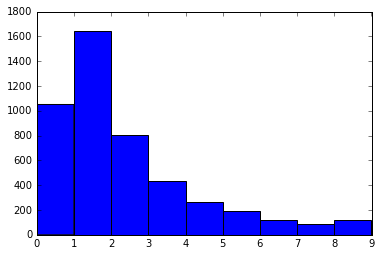

In [74]:
plt.hist(n_of_neighbours,range(10))

### Histograma cantidad de vecinos de hogar y trabajo (2 rois) entre abril y septiembre

In [44]:
n10_of_neighbours = filter(lambda x: x>9,n_of_neighbours)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([ 0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
         0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3       ,
         0.33333333,  0.36666667,  0.4       ,  0.43333333,  0.46666667,
         0.5       ,  0.53333333,  0.56666667,  0.6       ,  0.63333333,
         0.66666667,  0.7       ,  0.73333333,  0.76666667,  0.8       ,
         0.83333333,  0.86666667,  0.9       ,  0.93333333,  0.96666667,  1.        ]),
 <a list of 30 Patch objects>)

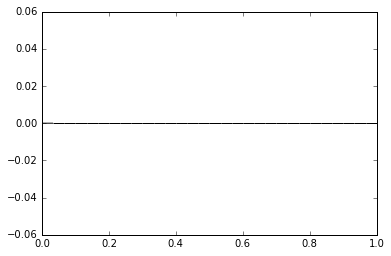

In [45]:
plt.hist(n10_of_neighbours,30)

## Seleccionar Features para la comparación

In [139]:
features_names = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin","card_type",\
    "start_time","end_time","traveled_days","traveled_days_bs","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips"]

In [140]:
features_dict = {"msal":0,"mlal":1,"kmDistance":2,"kmMaxDist":3,"kmMinDist":4,"rg":5,"unc_entropy":6,
                  "random_entropy":7,"p100_diff_last_origin":8,"p100_diff_first_origin":9,"card_type":10,
                  "start_time":11,"end_time":12,"traveled_days":13,"traveled_days_bs":14,"frequence_regularity":15,
                  "p100_exclusive_bus_days":16,"p100_exclusive_metro_days":17,"P100_bus_trips":18}

In [141]:
selected_features = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin",\
    "start_time","end_time","traveled_days","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips"]


In [142]:
#selected_features = features_names

In [143]:
len(selected_features)

17

In [144]:
abril_selected_features = filter_features(abril_vectors,selected_features)
septiembre_selected_features = filter_features(septiembre_vectors,selected_features)

## Normalizar con respecto a los vecinos

In [145]:
abril_selected_features.shape

(5169, 17)

## Hacer las comparaciones

### Seleccionar solo los que se tiene un match

In [146]:
a_matrix_unique_match = only_one_match_home_and_work(limit,shared_rois)

0.0594351291656


In [147]:
n_identified_unique_match,selected_distance_unique_match,identified_indexs_unique_match,abstenidos_unique_match = get_n_correct(a_matrix_unique_match,limit)

In [148]:
porcentaje_correcto_unique_match = n_identified_unique_match*100/limit
print str(round(porcentaje_correcto_unique_match,2))+ "%"

21.88%


### Seleccionar randommente entre los vecinos que matchean hogar y trabajo

In [198]:
a_matrix_random_match = random_match_home_and_work(limit,shared_rois)

0.0673789978027


In [199]:
n_identified_random_match,selected_distance_random_match,identified_indexs_random_match,abstenidos_random_match = get_n_correct(a_matrix_random_match,limit)

In [200]:
porcentaje_correcto_random_match = n_identified_random_match*100/limit
print str(round(porcentaje_correcto_random_match,2))+ "%"

28.86%


### Seleccionar con distancia euclidiana entre los vecinos

In [231]:
a_matrix = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.euclidean)

0.880834102631


In [232]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix,limit)

In [233]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

21.88%


In [208]:
len(abstenidos)

2917

### Pruebas con diferentes distancias

#### Euclidiana

In [222]:
a_matrix_euclidiana = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.euclidean)

0.910756111145


In [223]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_euclidiana,limit)

In [224]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

21.88%


#### Manhattan

In [79]:
a_matrix_manhattan = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.cityblock)

0.986017942429


In [80]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_manhattan,limit)

In [81]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

21.88%


#### braycurtis

In [82]:
a_matrix_braycurtis = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.braycurtis)

1.14211893082


In [83]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_braycurtis,limit)

In [84]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

21.88%


#### hamming

In [85]:
a_matrix_hamming = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.hamming)

1.11662602425


In [86]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_hamming,limit)

In [87]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

21.88%


#### chebyshev

In [88]:
a_matrix_chebyshev= compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.chebyshev)

0.980829954147


In [89]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_chebyshev,limit)

In [90]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

21.88%
